In [21]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,KFold,cross_validate,GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import pickle


In [3]:
df=pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Data Understanding

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  7043 non-null   str    
 17  Paymen

In [4]:
df.drop("customerID",axis=1,inplace=True)

In [22]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
numerical_cols=["tenure","MonthlyCharges","TotalCharges"]
for col in df.columns:
    if col not in numerical_cols:
        print(col)
        print(df[col].unique())
        print("*"*50)

gender
<StringArray>
['Female', 'Male']
Length: 2, dtype: str
**************************************************
SeniorCitizen
[0 1]
**************************************************
Partner
<StringArray>
['Yes', 'No']
Length: 2, dtype: str
**************************************************
Dependents
<StringArray>
['No', 'Yes']
Length: 2, dtype: str
**************************************************
PhoneService
<StringArray>
['No', 'Yes']
Length: 2, dtype: str
**************************************************
MultipleLines
<StringArray>
['No phone service', 'No', 'Yes']
Length: 3, dtype: str
**************************************************
InternetService
<StringArray>
['DSL', 'Fiber optic', 'No']
Length: 3, dtype: str
**************************************************
OnlineSecurity
<StringArray>
['No', 'Yes', 'No internet service']
Length: 3, dtype: str
**************************************************
OnlineBackup
<StringArray>
['Yes', 'No', 'No internet service']
Length: 3, 

In [5]:
target="Churn"
df[target].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [14]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
## changing total charges data type to float
df["TotalCharges"]=df["TotalCharges"].astype(float)

ValueError: could not convert string to float: ' '

In [7]:
## there is " " values in total charges so replace them and then changing data type
df["TotalCharges"]=df["TotalCharges"].replace({" ":"0"})
df["TotalCharges"]=df["TotalCharges"].astype(float)

In [8]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   str    
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   str    
 3   Dependents        7043 non-null   str    
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   str    
 6   MultipleLines     7043 non-null   str    
 7   InternetService   7043 non-null   str    
 8   OnlineSecurity    7043 non-null   str    
 9   OnlineBackup      7043 non-null   str    
 10  DeviceProtection  7043 non-null   str    
 11  TechSupport       7043 non-null   str    
 12  StreamingTV       7043 non-null   str    
 13  StreamingMovies   7043 non-null   str    
 14  Contract          7043 non-null   str    
 15  PaperlessBilling  7043 non-null   str    
 16  PaymentMethod     7043 non-null   str    
 17  Monthl

In [25]:
df[target]=df[target].replace({"Yes":0,"No":1})
df[target]=df[target].astype(int)

In [26]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   str    
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   str    
 3   Dependents        7043 non-null   str    
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   str    
 6   MultipleLines     7043 non-null   str    
 7   InternetService   7043 non-null   str    
 8   OnlineSecurity    7043 non-null   str    
 9   OnlineBackup      7043 non-null   str    
 10  DeviceProtection  7043 non-null   str    
 11  TechSupport       7043 non-null   str    
 12  StreamingTV       7043 non-null   str    
 13  StreamingMovies   7043 non-null   str    
 14  Contract          7043 non-null   str    
 15  PaperlessBilling  7043 non-null   str    
 16  PaymentMethod     7043 non-null   str    
 17  Monthl

#### Exploratory Data Analysis

In [28]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304,0.734630
std,0.368612,24.559481,30.090047,2266.794470,0.441561
min,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,398.550000,0.000000
50%,0.000000,29.000000,70.350000,1394.550000,1.000000
75%,0.000000,55.000000,89.850000,3786.600000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


##### Numerical column analysis

In [37]:
def hist_plot(col,data):
    plt.figure(figsize=(7,6))
    plt.title(f"Distribution of {col}")
    sns.histplot(data[col],kde=True)
    plt.show()

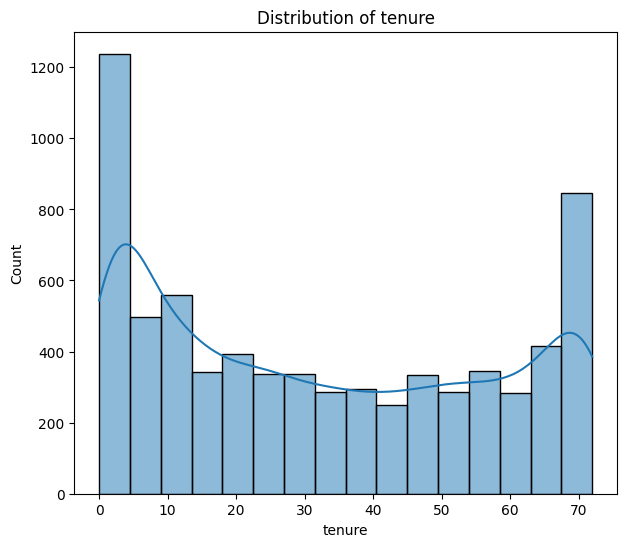

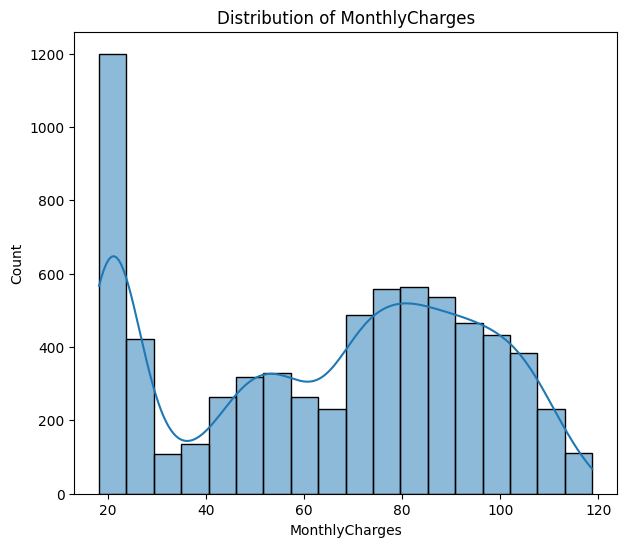

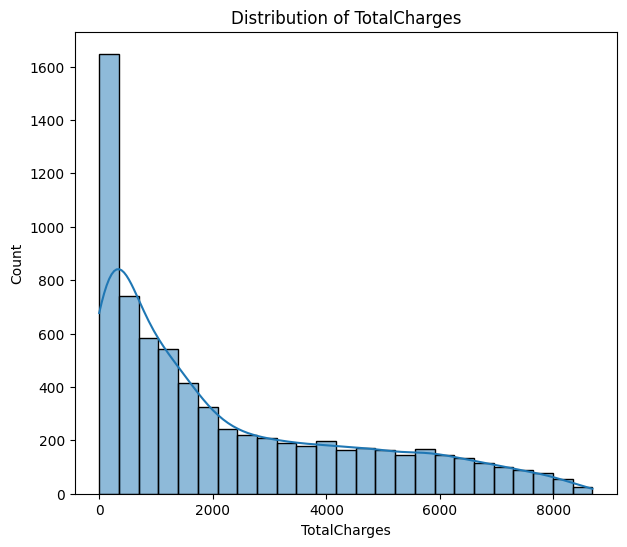

In [39]:
numerical_cols=["tenure","MonthlyCharges","TotalCharges"]

for col in numerical_cols:
    hist_plot(col,df)

In [41]:
def box_plot(col,data):
    plt.figure(figsize=(7,6))
    plt.title(f"Boxplot of {col}")
    sns.boxplot(y=data[col])
    plt.show()

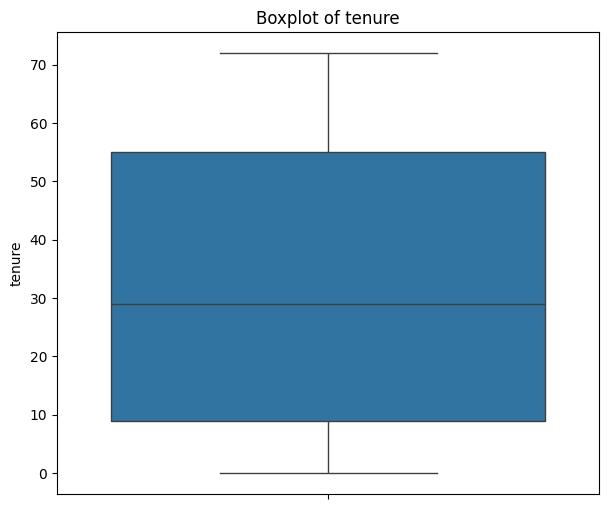

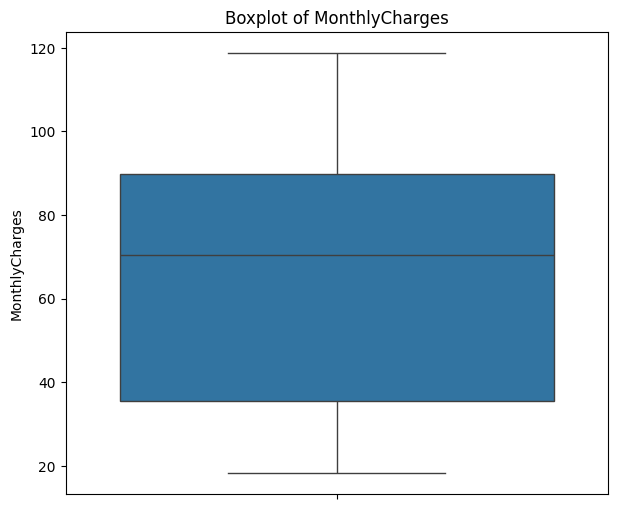

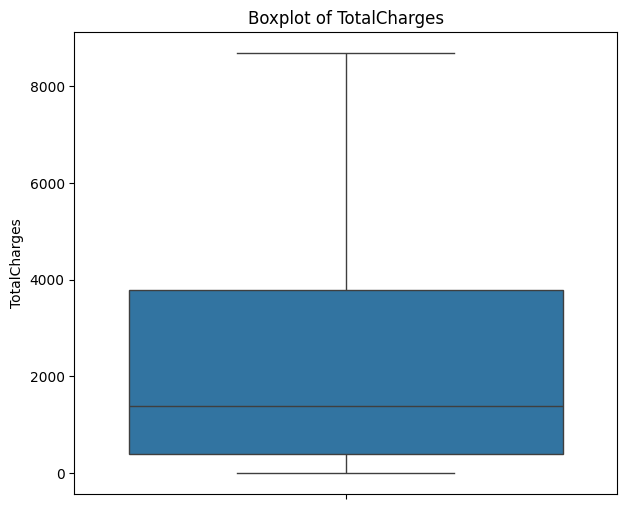

In [42]:
for col in numerical_cols:
    box_plot(col,df)

<Axes: >

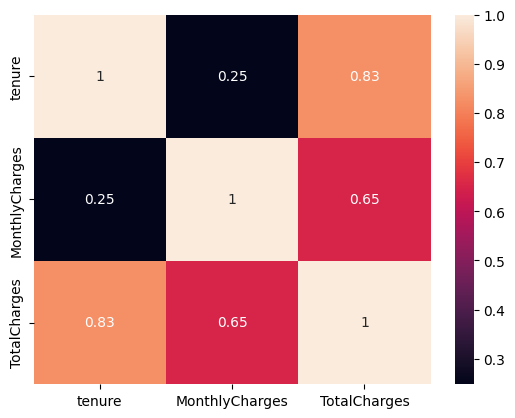

In [45]:
sns.heatmap(df[["tenure","MonthlyCharges","TotalCharges"]].corr(),annot=True)

#### Categorical Column Analysis

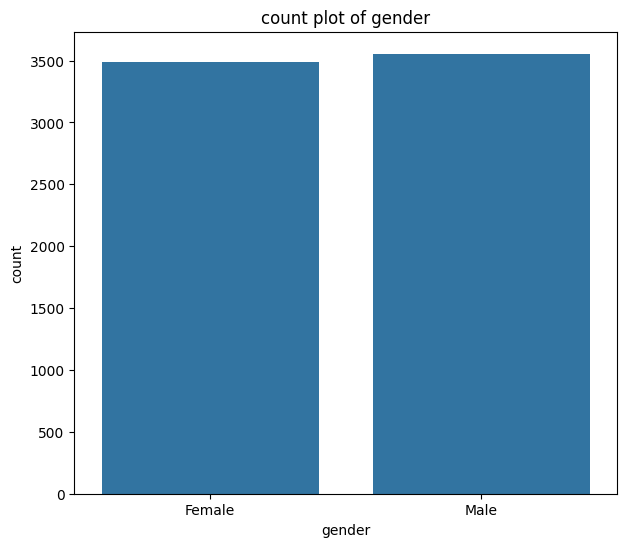

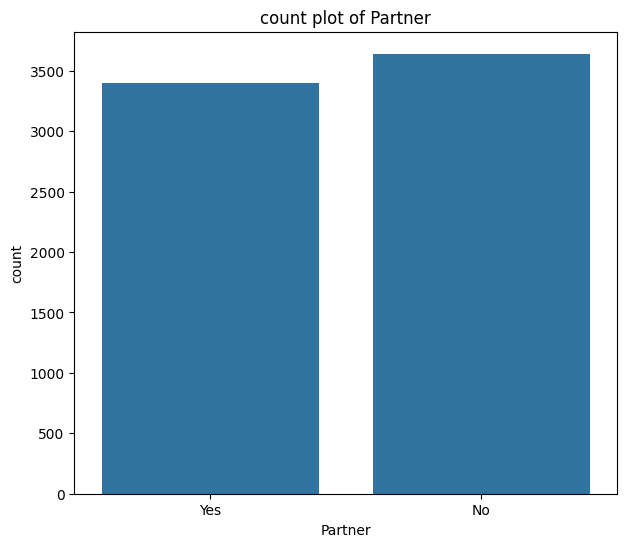

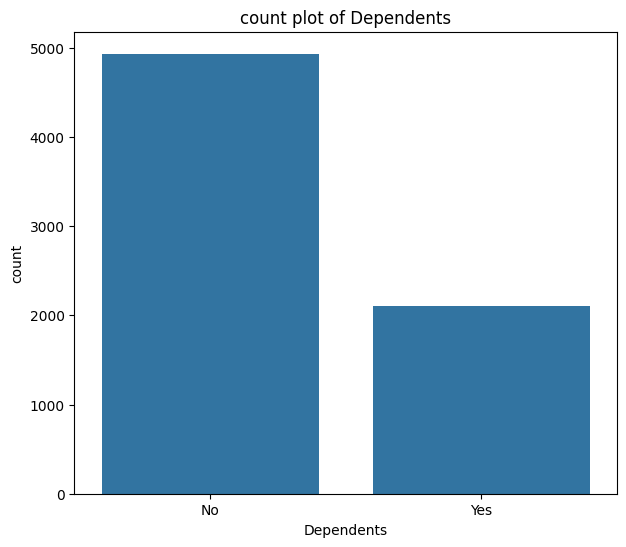

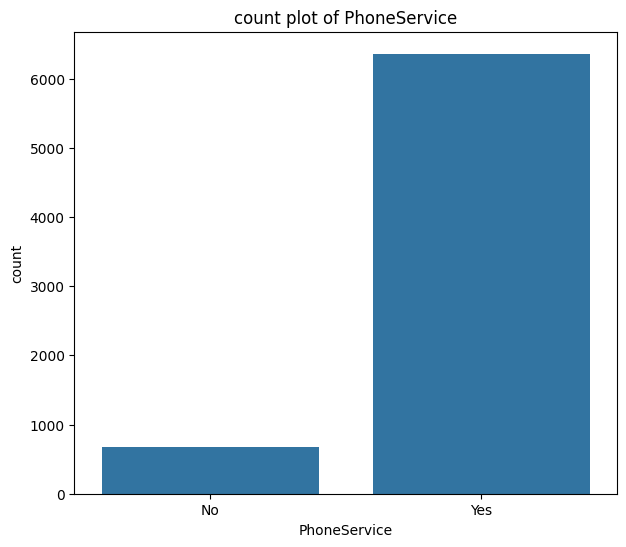

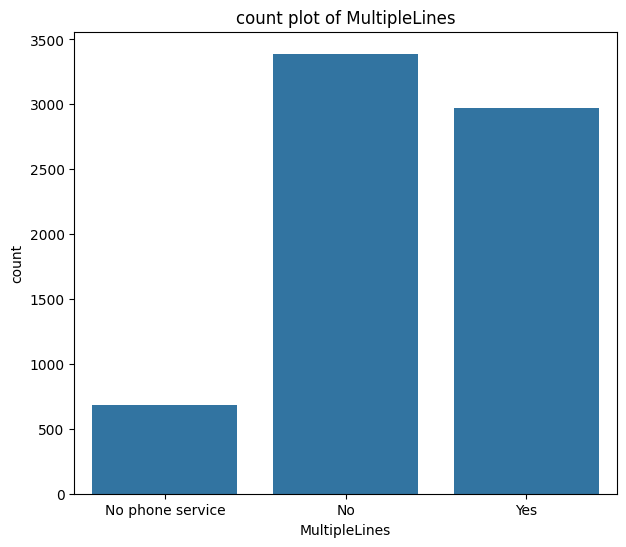

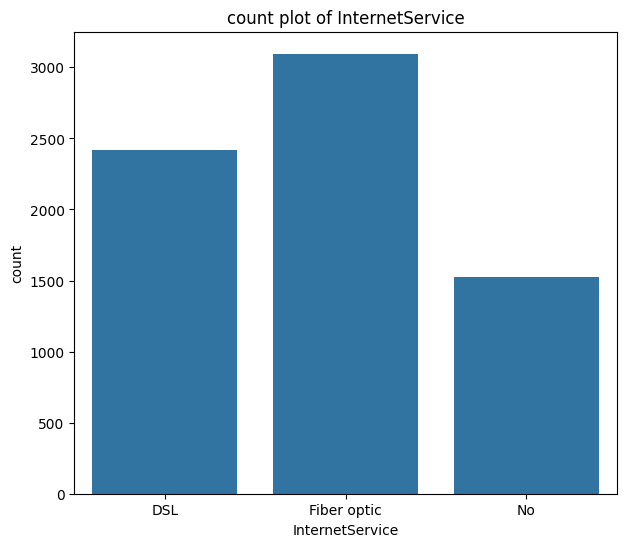

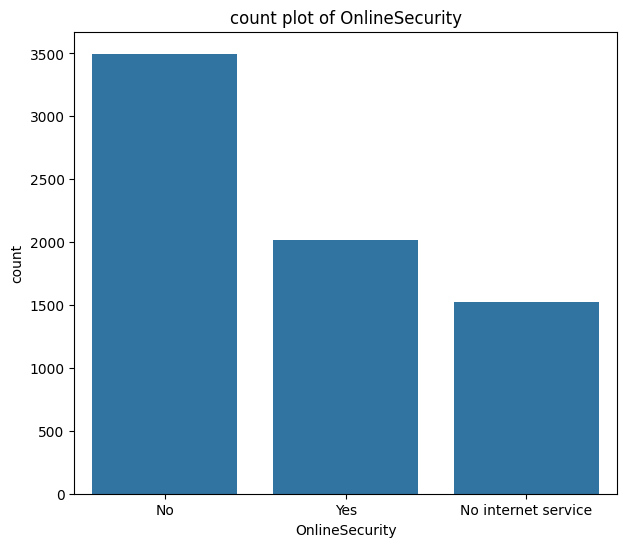

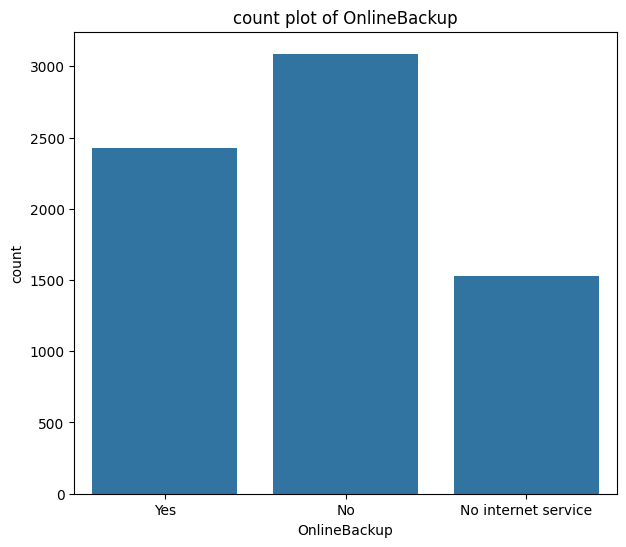

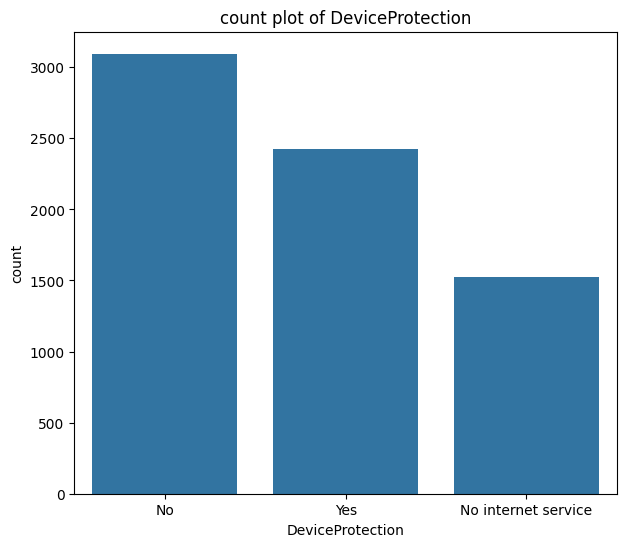

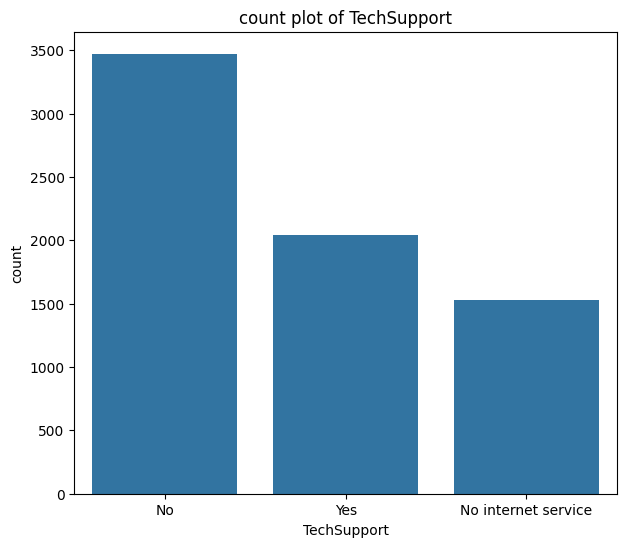

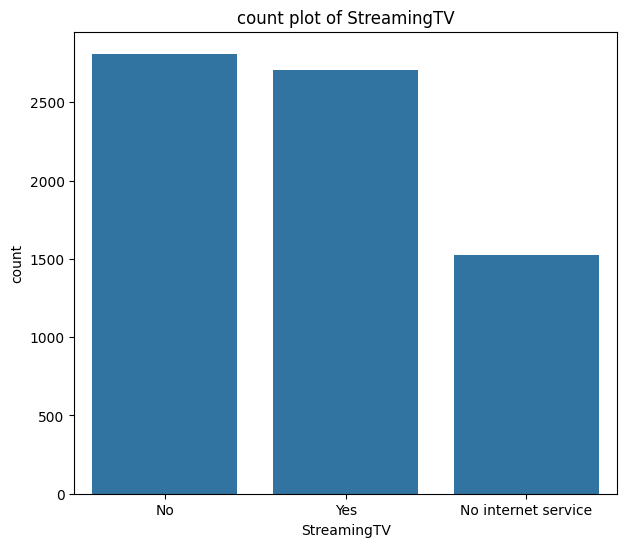

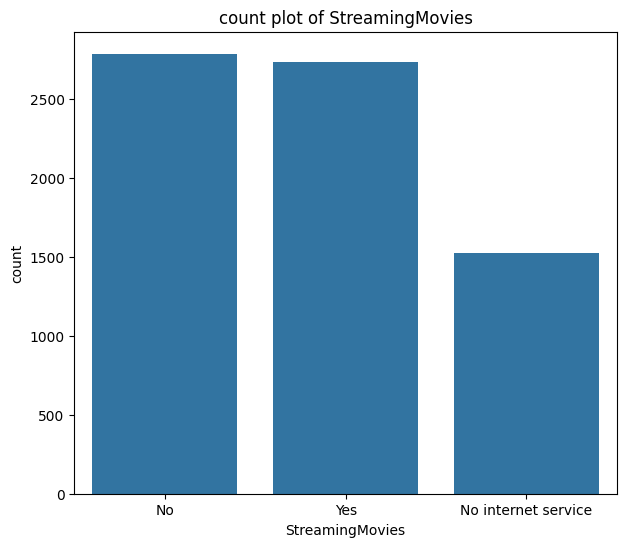

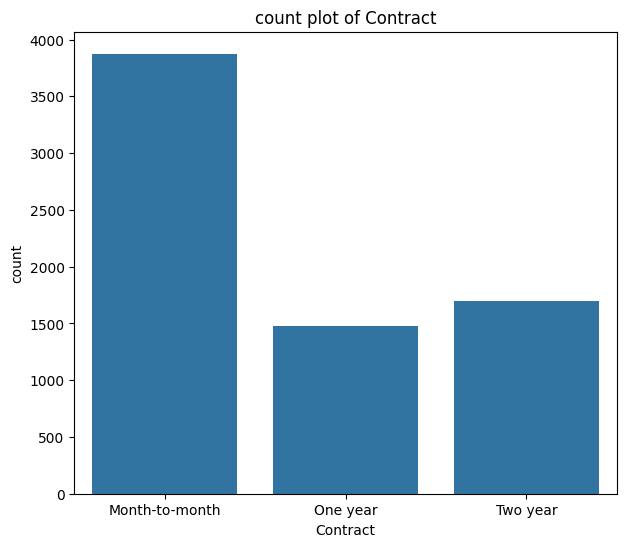

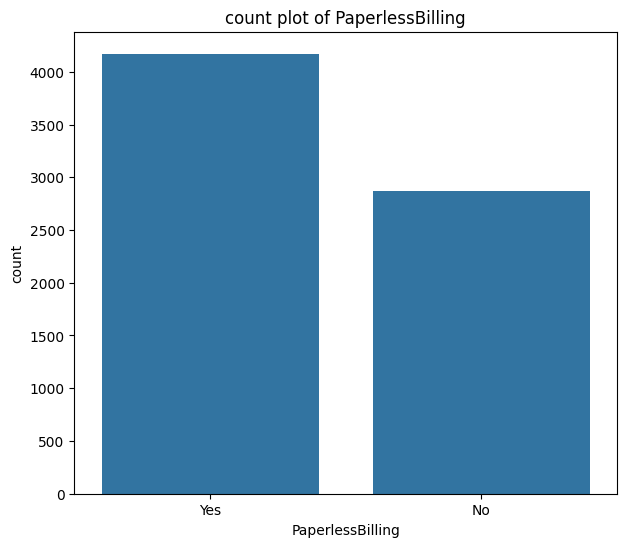

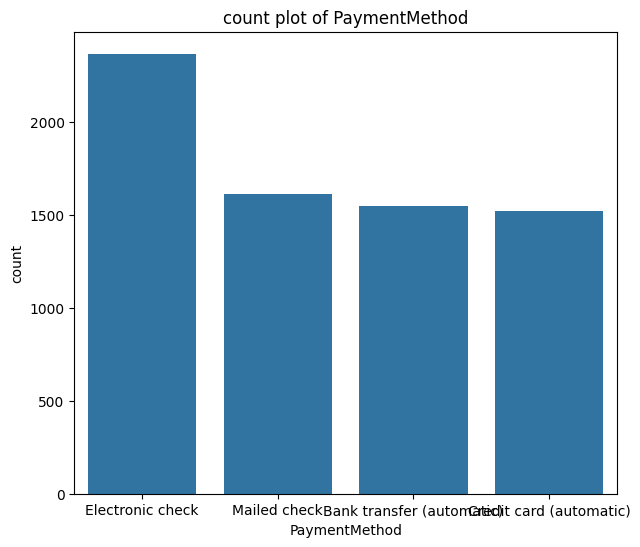

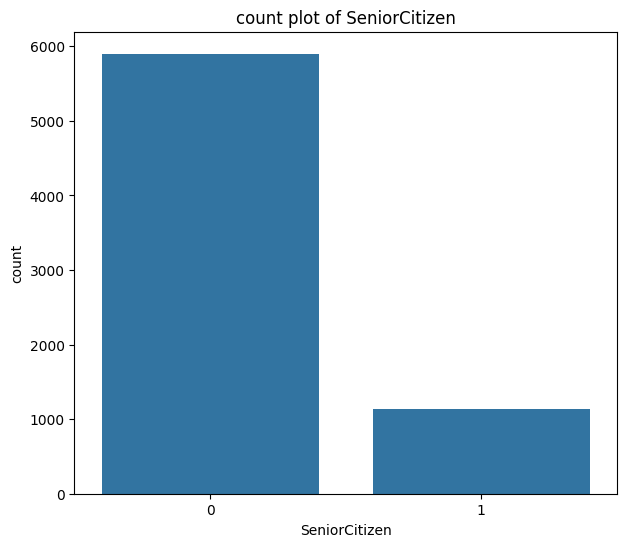

In [48]:
categorical_columns=df.select_dtypes(exclude=np.number).columns.to_list()
categorical_columns.append("SeniorCitizen")

for col in categorical_columns:
    plt.figure(figsize=(7,6))
    plt.title(f"count plot of {col}")
    sns.countplot(df,x=col)
    plt.show()

### Data Preprocessing

In [11]:
categorical_cols=df.select_dtypes(exclude=np.number).columns.to_list()
categorical_cols.append("SeniorCitizen")
numerical_cols=["tenure","MonthlyCharges","TotalCharges"]



In [12]:
encoders={}
for col in categorical_cols:
    encode=LabelEncoder()
    df[col]=encode.fit_transform(df[col])
    encoders[col]=encode

with open("encoders.pkl","wb") as file:
    pickle.dump(encoders,file)

In [13]:

x=df.drop(target,axis=1)
y=df[target]

In [15]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [16]:



numerical_pipe=Pipeline(
    steps=[
        ("Standard",StandardScaler())
    ]
)


preprocess=ColumnTransformer(
    transformers=[
        ("Numeric",numerical_pipe,numerical_cols)
    ]
)

### Model Training and Evalution


##### BaseLine model

In [17]:
model_pipe=Pipeline(
    steps=[
        ("preprocess",preprocess),
        ("smote",SMOTE(random_state=42)),
        ("model",LogisticRegression())
    ]
)

In [18]:
model_pipe.fit(X_train,y_train)

,steps,"[('preprocess', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('Numeric', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given strin

In [19]:
y_pred_train=model_pipe.predict(X_train)
accuracy_score(y_train,y_pred_train)

0.7147674831380901

#### Different Models

In [22]:
models={
    "Decission":DecisionTreeClassifier(),
    "RandomForestClassifier":RandomForestClassifier()
}

cv=KFold(n_splits=5,shuffle=True,random_state=42)

In [24]:
rows={}

for name,model in models.items():
    pipe=Pipeline(
        steps=[
        ("smote",SMOTE(random_state=42)),
        (name,model)
        ]
    )
    scores=cross_validate(pipe,X_train,y_train,cv=cv,n_jobs=1,verbose=1,scoring="accuracy")
    rows[name]=scores["test_score"].mean()

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s finished


In [25]:
rows

{'Decission': np.float64(0.721694843664549),
 'RandomForestClassifier': np.float64(0.7761838042808444)}

In [26]:
#selection randomforest classifier

In [ ]:
param_grid = {
    'model__n_estimators': [50, 100],          
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
}